# Import Modules

In [1]:
from tensorflow.keras.layers import Input, SimpleRNN, GRU, LSTM, Dense, Flatten, GlobalMaxPool1D, GRU
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.callbacks import EarlyStopping

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Helper Functions

In [2]:
def generate_dataset(series, T=10):
    T = T      # Use 10 steps back to predict next step
    D = 1       # univariate series
    X = []
    y = []

    for t in range(len(series) - T):
        X.append(series[t:t+T])
        y.append(series[t+T])

    X = np.array(X) # .reshape(-1, T)
    y = np.array(y)
    
    return X, y

In [3]:
def data_split(X, y):      
    N = len(X)
    X_train, X_val, X_test = X[:int(0.8 *N)], X[int(0.8 *N): -int(0.1*N)], X[-int(0.1*N):]
    y_train, y_val, y_test = y[:int(0.8 *N)], y[int(0.8 *N): -int(0.1*N)], y[-int(0.1*N):]
    return X_train, X_val, X_test, y_train, y_val, y_test

In [4]:
def one_step_pred_and_plot(model):
    fig, axes = plt.subplots(1, 2, figsize=(25, 5))

    y_pred = model.predict(X_test).flatten()

    axes[0].plot(y_test, label='targets')
    axes[0].plot(y_pred, label='predictions')
    axes[0].title.set_text("Linear Regression Predictions")
    axes[0].legend()
    # plt.show();

    y_pred = model.predict(X).flatten()

    axes[1].plot(y, label='targets')
    axes[1].plot(y_pred, label='predictions')
    axes[1].title.set_text("Linear Regression Predictions")
    axes[1].legend()

    plt.show();

In [5]:
def multi_step_pred_and_plot(model):
    # Multi-step forecast
    y_pred = []

    # first validation input
    last_X = X_test[0] # 1-D array of length T

    for i in range(len(X_test)):
        p = model.predict(last_X.reshape(1, -1))[0][0]
        y_pred.append(p)
        
        # roll first value to last and replace with pred result to make pred in the next iteration
        last_X = np.roll(last_X, -1)
        last_X[-1] = p

    plt.plot(y_test, label='forecast target')
    plt.plot(y_pred, label='forecast prediction')
    plt.legend();

# Create Dataset

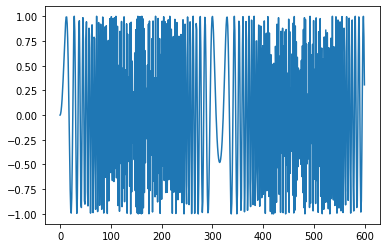

In [6]:
series = np.sin((0.1*np.arange(600))**2)
plt.plot(series);
plt.show();

In [19]:
X, y = generate_dataset(series, T=10)
print(X.shape, y.shape)     # created 590 samples, each has 10 steps for training and one next step for prediciton

N = len(X)
T = 10
D = 1

X_train, X_val, X_test, y_train, y_val, y_test = data_split(X, y)

(590, 10) (590,)


# Modeling

In [8]:
es = EarlyStopping(
    monitor='val_loss', 
    patience=8, 
    min_delta=0.001, 
    mode='min'
)

## Linear AR

In [9]:
X_train.shape   # 472 samples, each 10 steps (N x T)

(472, 10)

In [10]:
# Simple regression model
i = Input(shape=(T,))
x = Dense(1)(i)     # regression only need one unit at last without activation function

model = Model(i, x)
model.compile(
    loss='mse',
    optimizer=Adam(learning_rate=0.01)
)
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 10)]              0         
_________________________________________________________________
dense (Dense)                (None, 1)                 11        
Total params: 11
Trainable params: 11
Non-trainable params: 0
_________________________________________________________________


In [11]:
X_train[0]

array([0.        , 0.00999983, 0.03998933, 0.08987855, 0.15931821,
       0.24740396, 0.35227423, 0.47062589, 0.59719544, 0.72428717])

In [12]:
model.layers[1].get_weights()

[array([[ 0.08967668],
        [ 0.23404247],
        [-0.41434222],
        [ 0.14682889],
        [-0.17499578],
        [ 0.51673263],
        [ 0.11385137],
        [-0.41368842],
        [-0.5839143 ],
        [ 0.61678153]], dtype=float32), array([0.], dtype=float32)]

In [13]:
r = model.fit(
    X_train, y_train,
    epochs=50,
    validation_data=(X_val, y_val),
    callbacks=[es]
)

Epoch 1/50
15/15 [==============================] - 3s 11ms/step - loss: 1.2040 - val_loss: 1.3480
Epoch 2/50
15/15 [==============================] - 0s 3ms/step - loss: 0.8720 - val_loss: 0.9850
Epoch 3/50
15/15 [==============================] - 0s 3ms/step - loss: 0.6850 - val_loss: 0.8008
Epoch 4/50
15/15 [==============================] - 0s 3ms/step - loss: 0.5738 - val_loss: 0.6881
Epoch 5/50
15/15 [==============================] - 0s 4ms/step - loss: 0.5243 - val_loss: 0.6159
Epoch 6/50
15/15 [==============================] - 0s 3ms/step - loss: 0.5029 - val_loss: 0.5694
Epoch 7/50
15/15 [==============================] - 0s 3ms/step - loss: 0.4932 - val_loss: 0.5374
Epoch 8/50
15/15 [==============================] - 0s 3ms/step - loss: 0.4906 - val_loss: 0.5143
Epoch 9/50
15/15 [==============================] - 0s 3ms/step - loss: 0.4887 - val_loss: 0.5069
Epoch 10/50
15/15 [==============================] - 0s 3ms/step - loss: 0.4881 - val_loss: 0.4938
Epoch 11/50
15/15 

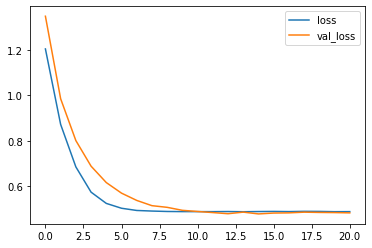

In [14]:
plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'], label='val_loss')
plt.legend()
plt.show();

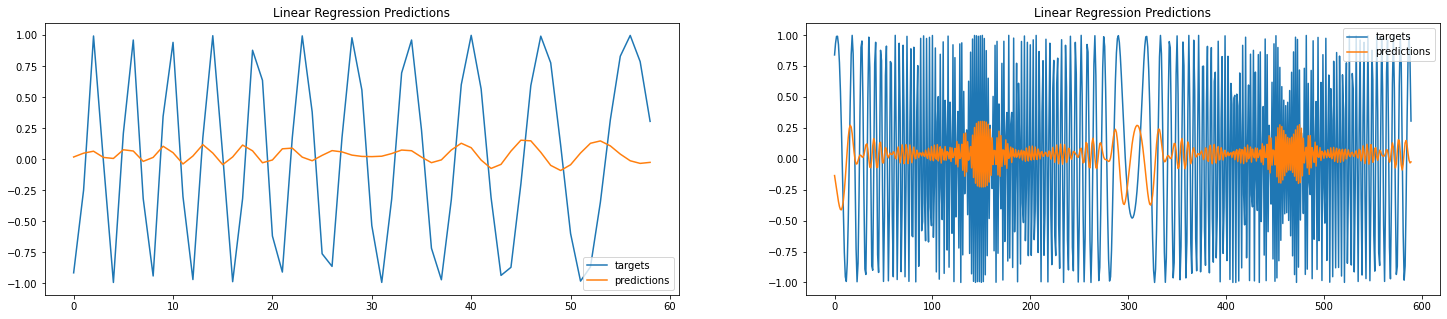

In [15]:
# One-step forecast
one_step_pred_and_plot(model)

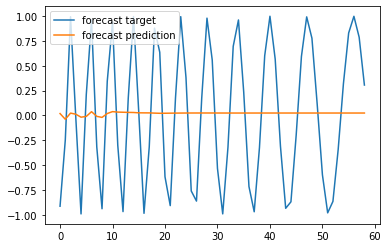

In [16]:
# Multi-step forecast
multi_step_pred_and_plot(model)

## Simple RNN

In [20]:
X = X.reshape(-1, T, 1)
X_train, X_val, X_test = X_train.reshape(-1, T, 1), X_val.reshape(-1, T, 1), X_test.reshape(-1, T, 1)
print(X.shape)    # 590 samples, each has 10 steps of 1D (N x T x D)
print(X[0])

(590, 10, 1)
[[0.        ]
 [0.00999983]
 [0.03998933]
 [0.08987855]
 [0.15931821]
 [0.24740396]
 [0.35227423]
 [0.47062589]
 [0.59719544]
 [0.72428717]]


In [21]:
M = 5 # number of hidden units
i = Input(shape=(T, D))
x = SimpleRNN(5)(i)     # , activation='relu'
x = Dense(1)(x)     # regression only need one unit at last without activation function
model = Model(i, x)

model.compile(
    loss='mse',
    # loss='binary_crossentropy',
    optimizer=Adam(learning_rate=0.05),
    # optimizer='rmsprop',
    # optimizer=SGD(lr=0.1, momentum=0.9),
    # metrics=['accuracy'],
)

model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 10, 1)]           0         
_________________________________________________________________
simple_rnn (SimpleRNN)       (None, 5)                 35        
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 6         
Total params: 41
Trainable params: 41
Non-trainable params: 0
_________________________________________________________________


In [22]:
r = model.fit(
    X_train, y_train,
    batch_size=32,
    epochs=200,
    validation_data=(X_val, y_val),
    callbacks=[es]
)

Epoch 1/200
15/15 [==============================] - 1s 19ms/step - loss: 0.5573 - val_loss: 0.4645
Epoch 2/200
15/15 [==============================] - 0s 9ms/step - loss: 0.5054 - val_loss: 0.4218
Epoch 3/200
15/15 [==============================] - 0s 9ms/step - loss: 0.4644 - val_loss: 0.4033
Epoch 4/200
15/15 [==============================] - 0s 9ms/step - loss: 0.4024 - val_loss: 0.3216
Epoch 5/200
15/15 [==============================] - 0s 9ms/step - loss: 0.3118 - val_loss: 0.2243
Epoch 6/200
15/15 [==============================] - 0s 10ms/step - loss: 0.2055 - val_loss: 0.1633
Epoch 7/200
15/15 [==============================] - 0s 9ms/step - loss: 0.1338 - val_loss: 0.1228
Epoch 8/200
15/15 [==============================] - 0s 9ms/step - loss: 0.1016 - val_loss: 0.0651
Epoch 9/200
15/15 [==============================] - 0s 9ms/step - loss: 0.0838 - val_loss: 0.0486
Epoch 10/200
15/15 [==============================] - 0s 10ms/step - loss: 0.0646 - val_loss: 0.0527
Epoch 

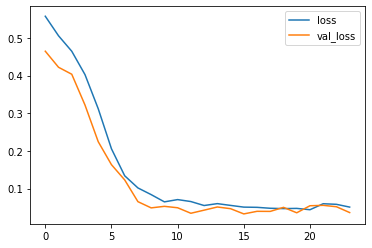

In [23]:
plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'], label='val_loss')
plt.legend()
plt.show();

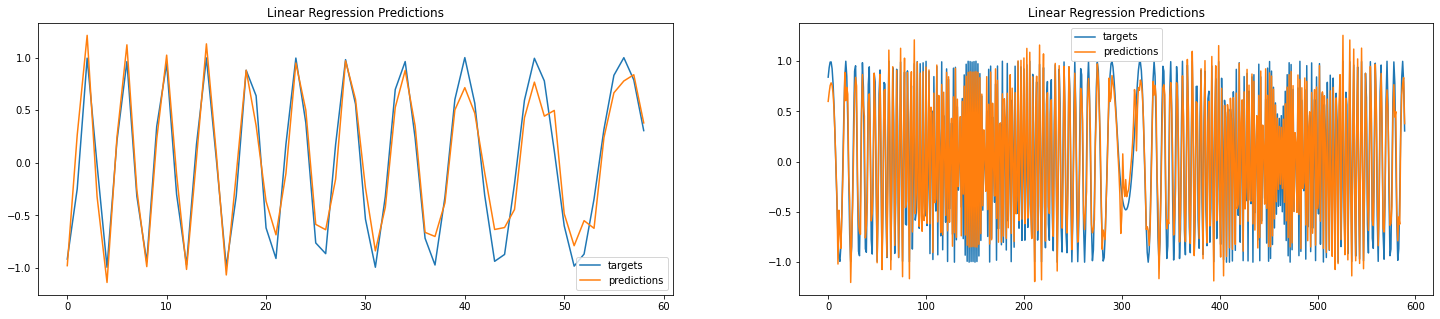

In [24]:
# One-step forecast
one_step_pred_and_plot(model)

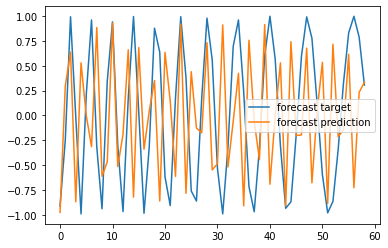

In [25]:
# Multi-step forecast
multi_step_pred_and_plot(model)

## GRU

In [26]:
M = 5 # number of hidden units
i = Input(shape=(T, D))
x = GRU(5)(i)     # , activation='relu'
x = Dense(1)(x)     # regression only need one unit at last without activation function
model = Model(i, x)

model.compile(
    loss='mse',
    optimizer=Adam(learning_rate=0.05),
)

model.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 10, 1)]           0         
_________________________________________________________________
gru (GRU)                    (None, 5)                 120       
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 6         
Total params: 126
Trainable params: 126
Non-trainable params: 0
_________________________________________________________________


In [27]:
r = model.fit(
   X_train, y_train,
    batch_size=32,
    epochs=200,
    validation_data=(X_val, y_val),
    callbacks=[es]
)

Epoch 1/200
15/15 [==============================] - 5s 25ms/step - loss: 0.5197 - val_loss: 0.4458
Epoch 2/200
15/15 [==============================] - 0s 4ms/step - loss: 0.5004 - val_loss: 0.4644
Epoch 3/200
15/15 [==============================] - 0s 4ms/step - loss: 0.4945 - val_loss: 0.4754
Epoch 4/200
15/15 [==============================] - 0s 4ms/step - loss: 0.4769 - val_loss: 0.3848
Epoch 5/200
15/15 [==============================] - 0s 4ms/step - loss: 0.4257 - val_loss: 0.3256
Epoch 6/200
15/15 [==============================] - 0s 4ms/step - loss: 0.3260 - val_loss: 0.1664
Epoch 7/200
15/15 [==============================] - 0s 4ms/step - loss: 0.1540 - val_loss: 0.1004
Epoch 8/200
15/15 [==============================] - 0s 4ms/step - loss: 0.0953 - val_loss: 0.1043
Epoch 9/200
15/15 [==============================] - 0s 4ms/step - loss: 0.0711 - val_loss: 0.0704
Epoch 10/200
15/15 [==============================] - 0s 4ms/step - loss: 0.0499 - val_loss: 0.0614
Epoch 11

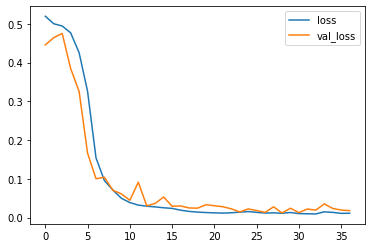

In [28]:
plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'], label='val_loss')
plt.legend()
plt.show();

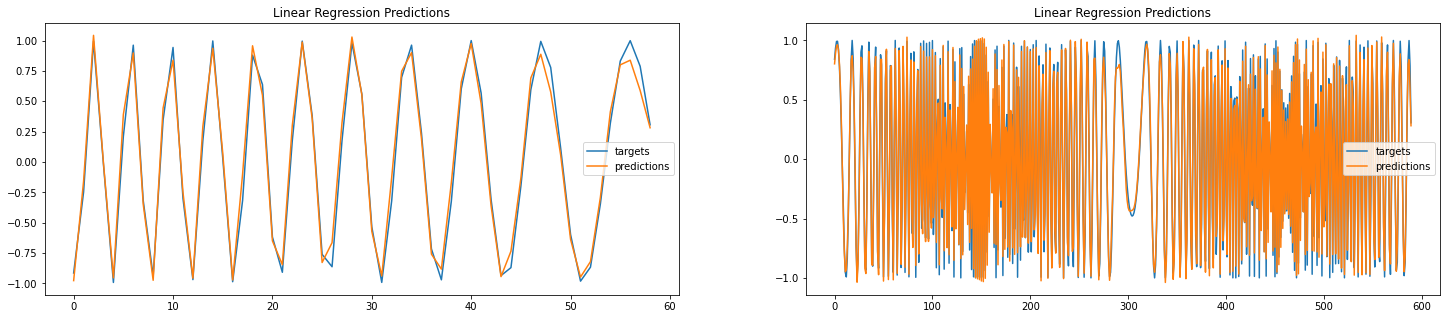

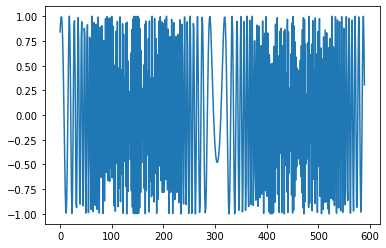

In [29]:
# One-step forecast
one_step_pred_and_plot(model)
plt.plot(y);

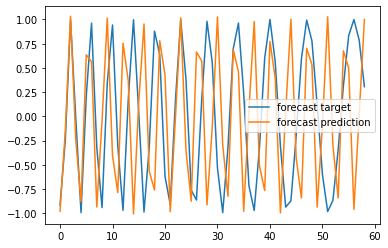

In [30]:
# Multi-step forecast
multi_step_pred_and_plot(model)

## LSTM

In [31]:
i = Input(shape=(T, D))
x = LSTM(10)(i)
x = Dense(1)(x)     # regression only need one unit at last without activation function
model = Model(i, x)

model.compile(
    loss='mse',
    optimizer=Adam(learning_rate=0.05),
)

model.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 10, 1)]           0         
_________________________________________________________________
lstm (LSTM)                  (None, 10)                480       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 11        
Total params: 491
Trainable params: 491
Non-trainable params: 0
_________________________________________________________________


In [32]:
r = model.fit(
   X_train, y_train,
    batch_size=32,
    epochs=200,
    validation_data=(X_val, y_val),
    callbacks=[es]
)

Epoch 1/200
15/15 [==============================] - 2s 29ms/step - loss: 0.5063 - val_loss: 0.4928
Epoch 2/200
15/15 [==============================] - 0s 5ms/step - loss: 0.4921 - val_loss: 0.4863
Epoch 3/200
15/15 [==============================] - 0s 5ms/step - loss: 0.4379 - val_loss: 0.3701
Epoch 4/200
15/15 [==============================] - 0s 4ms/step - loss: 0.2706 - val_loss: 0.1245
Epoch 5/200
15/15 [==============================] - 0s 4ms/step - loss: 0.1294 - val_loss: 0.0735
Epoch 6/200
15/15 [==============================] - 0s 5ms/step - loss: 0.0691 - val_loss: 0.0370
Epoch 7/200
15/15 [==============================] - 0s 4ms/step - loss: 0.0356 - val_loss: 0.0229
Epoch 8/200
15/15 [==============================] - 0s 5ms/step - loss: 0.0262 - val_loss: 0.0239
Epoch 9/200
15/15 [==============================] - 0s 4ms/step - loss: 0.0171 - val_loss: 0.0188
Epoch 10/200
15/15 [==============================] - 0s 4ms/step - loss: 0.0102 - val_loss: 0.0087
Epoch 11

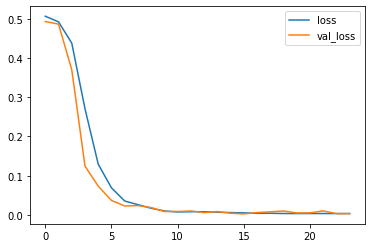

In [33]:
plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'], label='val_loss')
plt.legend()
plt.show();

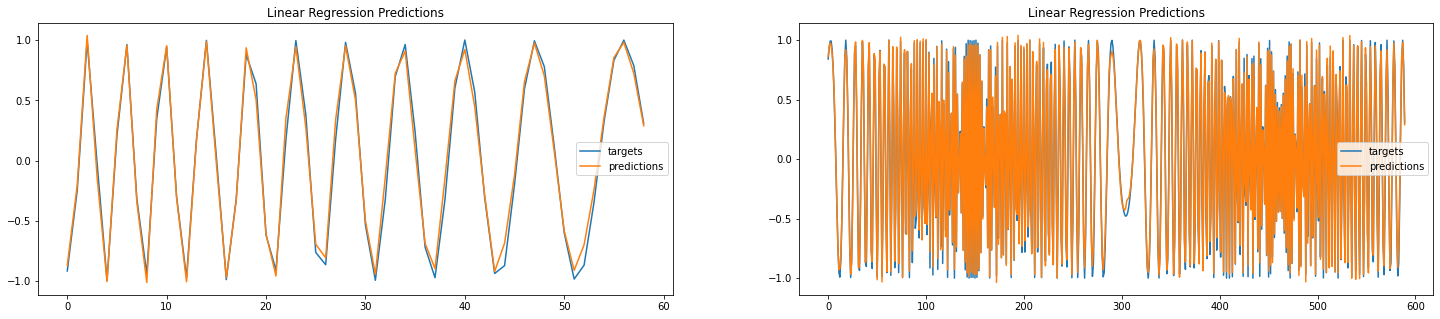

In [34]:
# One-step forecast
one_step_pred_and_plot(model)

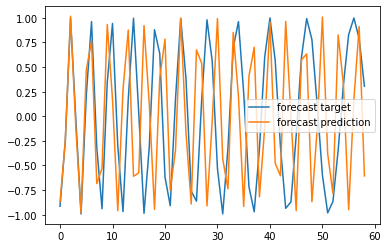

In [35]:
# Multi-step forecast
multi_step_pred_and_plot(model)

## LSTM + Pooling

In [39]:
# increase steps of each sample from 10 to 30
X, y = generate_dataset(series, T=30)
print(X.shape, y.shape)     # created 590 samples, each has 10 steps for training and one next step for prediciton

N = len(X)
T = 30

X_train, X_val, X_test, y_train, y_val, y_test = data_split(X, y)

(570, 30) (570,)


In [40]:
i = Input(shape=(T, D))
x = LSTM(10, return_sequences=True)(i)
x = GlobalMaxPool1D()(x)
x = Dense(1)(x)     # , activation='sigmoid'
model = Model(i, x)

model.compile(
    # loss='binary_crossentropy',
    loss='mse',
    optimizer=Adam(learning_rate=0.01),
    # metrics=['accuracy']
)

model.summary()

Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 30, 1)]           0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 30, 10)            480       
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 10)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 11        
Total params: 491
Trainable params: 491
Non-trainable params: 0
_________________________________________________________________


In [41]:
r = model.fit(
    X_train, y_train,
    batch_size=32,
    epochs=200,
    validation_data=(X_val, y_val),
    callbacks=[es]
)

Epoch 1/200
15/15 [==============================] - 2s 29ms/step - loss: 0.5127 - val_loss: 0.4878
Epoch 2/200
15/15 [==============================] - 0s 5ms/step - loss: 0.5063 - val_loss: 0.4865
Epoch 3/200
15/15 [==============================] - 0s 5ms/step - loss: 0.5057 - val_loss: 0.4858
Epoch 4/200
15/15 [==============================] - 0s 5ms/step - loss: 0.5034 - val_loss: 0.4848
Epoch 5/200
15/15 [==============================] - 0s 6ms/step - loss: 0.5027 - val_loss: 0.4852
Epoch 6/200
15/15 [==============================] - 0s 6ms/step - loss: 0.5006 - val_loss: 0.4845
Epoch 7/200
15/15 [==============================] - 0s 5ms/step - loss: 0.5020 - val_loss: 0.4849
Epoch 8/200
15/15 [==============================] - 0s 5ms/step - loss: 0.5025 - val_loss: 0.4846
Epoch 9/200
15/15 [==============================] - 0s 5ms/step - loss: 0.5032 - val_loss: 0.4844
Epoch 10/200
15/15 [==============================] - 0s 5ms/step - loss: 0.5012 - val_loss: 0.4843
Epoch 11

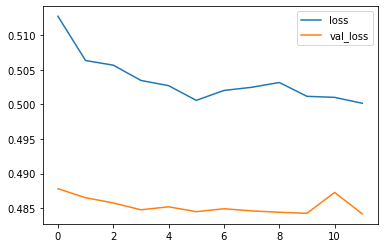

In [42]:
plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'], label='val_loss')
plt.legend()
plt.show();

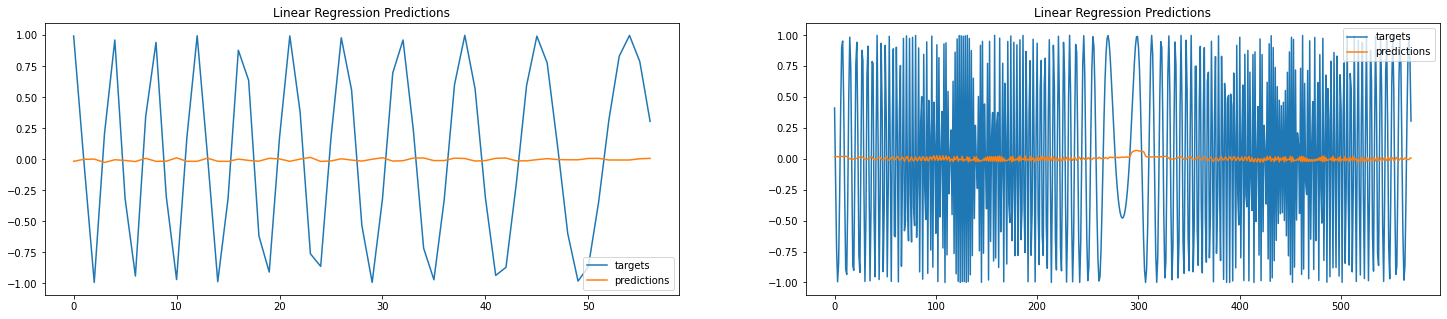

In [43]:
# One-step forecast
one_step_pred_and_plot(model)

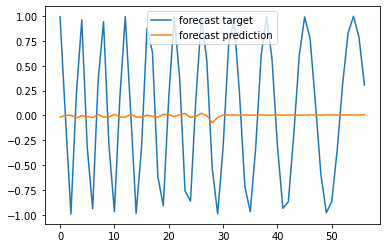

In [44]:
# Multi-step forecast
multi_step_pred_and_plot(model)